Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1157
307
Epoch 1/45
19/19 [==============================] - 95s 5s/step - loss: 1.9519 - accuracy: 0.4909 - val_loss: 2.9974 - val_accuracy: 0.0717
Epoch 2/45
19/19 [==============================] - 89s 5s/step - loss: 1.0609 - accuracy: 0.7398 - val_loss: 2.9752 - val_accuracy: 0.1303
Epoch 3/45
19/19 [==============================] - 89s 5s/step - loss: 0.8104 - accuracy: 0.8047 - val_loss: 2.9609 - val_accuracy: 0.0945
Epoch 4/45
19/19 [==============================] - 89s 5s/step - loss: 0.6119 - accuracy: 0.8626 - val_loss: 2.9461 - val_accuracy: 0.0945
Epoch 5/45
19/19 [==============================] - 90s 5s/step - loss: 0.5144 - accuracy: 0.8842 - val_loss: 2.9304 - val_accuracy: 0.0879
Epoch 6/45
19/19 [==============================] - 90s 5s/step - loss: 0.4320 - accuracy: 0.9049 - val_loss: 2.9052 - val_accuracy: 0.0684
Epoch 7/45
19/19 [==

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/covid_ready4/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/covid_ready4/assets


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1272, 64)          22016     
_________________________________________________________________
batch_normalization_9 (Batch (None, 1272, 64)          256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 1272, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1272, 128)         98816     
_________________________________________________________________
batch_normalization_10 (Batc (None, 1272, 128)         512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 1272, 128)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)               

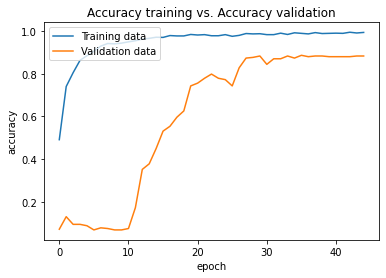

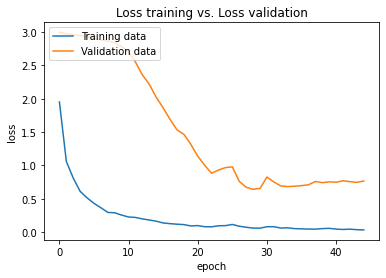

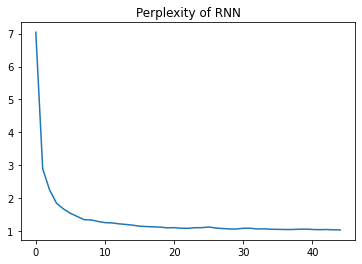

In [5]:
import numpy as np
import math
import statistics
import tensorflow as tf
import string
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.python.framework import ops
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing


# We mount our Google Drive that contains the datasets
drive.mount('/content/gdrive')


############# the code for this class came from Google's RNN Text Generation page but has been modified to work witht he current RNN ###############
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  #@tf.function
  def generate_one_step(self, inputs):

    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # convert the input into one hot tensors
    input_ids = tf.one_hot(input_ids,21)
    input_ids = ops.convert_to_tensor(input_ids, dtype=tf.float32)


    # Run the model.
    predicted_logits = self.model(inputs=input_ids)
    
    
    # Only use the last prediction.

    predicted_logits = predicted_logits / self.temperature


    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask


    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)


    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)
    

    # Return the characters.
    return predicted_chars



##### end of class #####





# convert made up sequence to a tensor
# line is the temp[0] pass as an argument here
def FlipChars(line):
  testlabel = []
  test = []
  temp = line.split()
  charList = list(temp)
  seq = []

  for i in range(50): # convert each letter into an int, randomly flip a char or more 
    
    # these 3 if conditions randomly flip a character letter to find dependeny, can comment out either or for experimentation
    if i == 15:
      seq.append(ord(string.ascii_uppercase[random.randint(0,26)]) - ord('A') + 1)
      continue

    if i == 25:
      seq.append(ord(string.ascii_uppercase[random.randint(0,26)]) - ord('A') + 1)
      continue

    if i >= 45:
      seq.append(ord(string.ascii_uppercase[random.randint(0,26)]) - ord('A') + 1)
      continue

    seq.append(ord(charList[i]) - ord('A') + 1)
        
  # grab the labels and convert seq into a one hot encoding of 21
  if seq[len(seq)-1] > 20:
    seq[len(seq)-1] = 20

  # get one hot tensor and test label
  label = seq[len(seq)-1]
  seq = tf.one_hot(seq,21)
  test.append(seq[:len(seq)-1])
  testlabel.append(label)

  # convert labels to tensors and one hot to a tensor again
  test_label = np.asarray(test_label).astype('float32').reshape((-1,1))
  test_label = ops.convert_to_tensor(test_label, dtype=tf.float32)
  test = ops.convert_to_tensor(seq, dtype=tf.float32)

  return test, test_label




### The function for gathering tests
def read_seqV2(sequence):
    f = open(sequence, 'r')
    test = []
    testlabel = []

    # Reading file and extracting paths and labels
    with open(sequence, 'r') as File:
      infoFile = File.readlines() # Reading all the lines from File
      count = 0
      
      for line in infoFile: #Reading line-by-line
        # get testing data
        if count % 5 == 0: # else, put it in a the training set, also known as x_train, and training label set, also known as y_train.
          temp = line.split()
          charList = list(temp[0])
          seq = []
          
          # if for some reason the protein sequence is less than 50 char long
          if len(charList) < 1273:
            pass

          else:
            for i in range(1273): # convert each letter into an int
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            # grab the labels and convert seq into a one hot encoding of 21
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            seq = tf.one_hot(seq,21)
            test.append(seq[:len(seq)-1])
            testlabel.append(label)
            seq = []

        count += 1
        
      return test, testlabel




#### The function for reading and parsing file
def read_seq(sequence):
    f = open(sequence, 'r')
    train = []
    trainlabel = []

    # Reading file and extracting paths and labels
    with open(sequence, 'r') as File:
      infoFile = File.readlines() # Reading all the lines from File
      count = 0
      
      for line in infoFile: #Reading line-by-line
        if count == 400000:
          return train, trainlabel

        # training data addin
        if count % 5 != 0: # training data found
          temp = line.split()
          charList = list(temp[0])
          seq = []
          
          # if for some reason the protein sequence is less than 50 char long
          if len(charList) < 1273:
            pass

          else:
            for i in range(1273): # convert each letter into an int
              seq.append(ord(charList[i]) - ord('A') + 1)
            
            # grab the labels and convert seq into a one hot encoding of 21
            if seq[len(seq)-1] > 20:
               seq[len(seq)-1] = 20

            label = seq[len(seq)-1]
            seq = tf.one_hot(seq,21)
            train.append(seq[:len(seq)-1])
            trainlabel.append(label)
            seq = []

        count += 1



# We parse files to get training data
seq_train, train_label = read_seq('/content/gdrive/My Drive/pdb_seqres.txt')
seq_test, test_label = read_seqV2('/content/gdrive/My Drive/pdb_seqres.txt')

print(str(len(seq_train)))
print(str(len(seq_test)))

# We reshape labels to be 2d arrays
train_label = np.asarray(train_label).astype('float32').reshape((-1,1))
test_label = np.asarray(test_label).astype('float32').reshape((-1,1))

# We convert labels (y_train and y_test) to tensors
train_label = ops.convert_to_tensor(train_label, dtype=tf.float32)
test_label = ops.convert_to_tensor(test_label, dtype=tf.float32)

# We make the training and testing tensors floats instead of ints
seq_train = ops.convert_to_tensor(seq_train, dtype=tf.float32)
seq_test = ops.convert_to_tensor(seq_test, dtype=tf.float32)

# We create out recurrent neural network (RNN) 
# low dropout == better accuracy
model = keras.Sequential(
    [
     layers.LSTM(64, return_sequences=True, activation='relu'), # LSTM layer
     layers.BatchNormalization(), 
     layers.Dropout(0.1),
     layers.LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform', activation='tanh', bias_initializer='zeros'), # This is the LSTM layer with weights initialized
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.LSTM(64, return_sequences=False, activation='tanh'), # LSTM layer
     layers.BatchNormalization(), 
     layers.Dropout(0.3),
     layers.Dense(21, activation='softmax') # Output layer
    ]
)

"""
For extra credit portion - testing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

Optimizer.apply_gradients(
    grads_and_vars, name=None, experimental_aggregate_gradients=True
)
"""

# We compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# We get the history of the model to plot stuff
historyMod = model.fit(x=seq_train, y=train_label, shuffle=True, epochs=45, batch_size=64, validation_data=(seq_test, test_label))


# save the model
model.save('/content/gdrive/My Drive/covid_ready4')

# We print out a summary of our model
model.summary()

# We plot results of the training model
plt.plot(historyMod.history['accuracy'], label='Training data')
plt.plot(historyMod.history['val_accuracy'], label='Validation data')
plt.title('Accuracy training vs. Accuracy validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

# We plot the loss
plt.plot(historyMod.history['loss'], label='Training data')
plt.plot(historyMod.history['val_loss'], label='Validation data')
plt.title('Loss training vs. Loss validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

# This portion takes care of the perplexity plotting
perplexity = tf.exp(historyMod.history['loss'])
plt.plot(perplexity)
plt.title('Perplexity of RNN')
plt.show()
